In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
# from keras.layers.normalization import BatchNormalization
from keras import optimizers
IMG_SIZE = 128

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:54<00:00, 99.6MB/s]
100% 4.00G/4.00G [00:54<00:00, 78.3MB/s]


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip


Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [ ]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/imgs/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/content/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
driv_selected = ['p050', 'p015', 'p022', 'p056',"p016","p049"] # testing images

In [ ]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)

    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)

print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

16643 5781
16643 5781


In [ ]:
# 19526 2898
# 19526 2898

In [ ]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,3)
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(16643, 128, 128, 3)


In [ ]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (IMG_SIZE, IMG_SIZE, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMG_SIZE,IMG_SIZE,3))
model_resnet50_conv.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:

from keras.models import Model


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers

x=GlobalAveragePooling2D()(output_resnet50_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(inputs= resnet50_input, outputs = x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


resnet50_pretrained.summary()

# Compile CNN model
# adam = keras.optimizers.Adam(learning_rate=0.001)
sgd = optimizers.SGD(learning_rate = 0.001)
resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                             

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


In [ ]:
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 32)


In [ ]:
# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 75, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/75
261/260 [==============================] - ETA: 0s - loss: 2.8255 - accuracy: 0.1300
Epoch 1: val_loss improved from inf to 2.29406, saving model to resnet_weights.hdf5
260/260 [==============================] - 90s 247ms/step - loss: 2.8255 - accuracy: 0.1300 - val_loss: 2.2941 - val_accuracy: 0.1754
Epoch 2/75
261/260 [==============================] - ETA: 0s - loss: 2.4650 - accuracy: 0.1883
Epoch 2: val_loss improved from 2.29406 to 1.94912, saving model to resnet_weights.hdf5
260/260 [==============================] - 64s 246ms/step - loss: 2.4650 - accuracy: 0.1883 - val_loss: 1.9491 - val_accuracy: 0.3050
Epoch 3/75
261/260 [==============================] - ETA: 0s - loss: 2.1037 - accuracy: 0.2805
Epoch 3: val_loss improved from 1.94912 to 1.49961, saving model to resnet_weights.hdf5
260/260 [==============================] - 62s 238ms/step - loss: 2.1037 - accuracy: 0.2805 - val_loss: 1.4996 - val_accuracy: 0.4790
Epoch 4/75
261/260 [==============================

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ModelCheckpoint,EarlyStopping

# checkpointer = ModelCheckpoint('resnet_weights_aug_extralayers_sgd_setval.hdf5', verbose=1, save_best_only=True)
# earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


# datagen = ImageDataGenerator(
#     height_shift_range=0.5,
#     width_shift_range = 0.5,
#     zoom_range = 0.5,
#     rotation_range=30
#         )
# #datagen.fit(X_train)
# data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# # Fits the model on batches with real-time data augmentation:
# resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
#                                                             epochs = 40, verbose = 1, validation_data = (X_test, y_test))


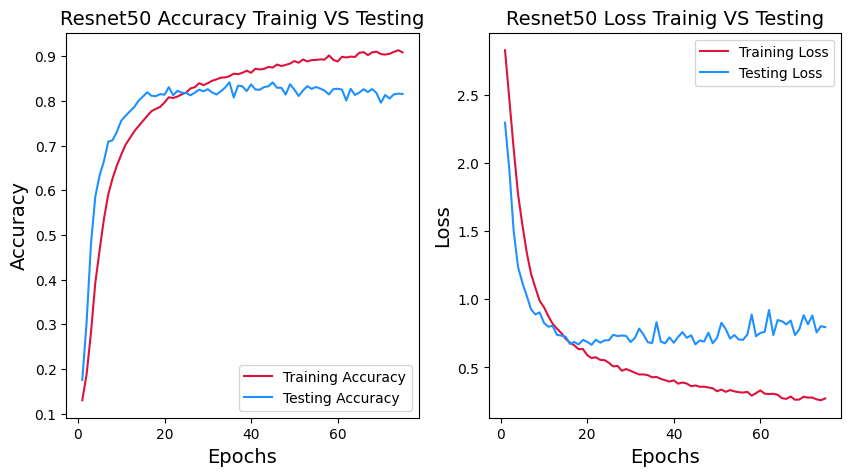

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid',color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('Resnet50 Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('Resnet50 Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [ ]:
# Fits the model for another 45 epochs
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 100, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/45
306/305 [==============================] - ETA: 0s - loss: 1.4268 - accuracy: 0.5032
Epoch 1: val_loss improved from 1.14245 to 1.12491, saving model to resnet_weights.hdf5
305/305 [==============================] - 65s 211ms/step - loss: 1.4268 - accuracy: 0.5032 - val_loss: 1.1249 - val_accuracy: 0.6039
Epoch 2/45
306/305 [==============================] - ETA: 0s - loss: 1.3972 - accuracy: 0.5083
Epoch 2: val_loss improved from 1.12491 to 1.11312, saving model to resnet_weights.hdf5
305/305 [==============================] - 72s 234ms/step - loss: 1.3972 - accuracy: 0.5083 - val_loss: 1.1131 - val_accuracy: 0.6090
Epoch 3/45
306/305 [==============================] - ETA: 0s - loss: 1.3990 - accuracy: 0.5051
Epoch 3: val_loss improved from 1.11312 to 1.09797, saving model to resnet_weights.hdf5
305/305 [==============================] - 71s 231ms/step - loss: 1.3990 - accuracy: 0.5051 - val_loss: 1.0980 - val_accuracy: 0.6132
Epoch 4/45
306/305 [==========================

In [ ]:
resnet50_pretrained.save("/content/model/resnetModel01.h5")

In [ ]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/home/jupyter/TestImages')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/home/jupyter/TestImages/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [ ]:
test = []

for img in test_image:
    test.append(img)

resnet50_pretrained.load_weights('resnet_weights_aug_extralayers_sgd_setval.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = resnet50_pretrained.predict(test)

In [ ]:
prediction[0]

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

